In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential
from kernels.matern import Matern
import math
import pytorch_finufft.functional as pff
# import sys
# sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/Tests and Sanity Checks/')
from efgpnd import ToeplitzND, compute_convolution_vector_vectorized_dD, _cmplx, nufft_var_est_nd, diag_sums_nd, efgp_nd, EFGPND, efgpnd_gradient_batched
import warnings
warnings.filterwarnings("ignore", message=".*disabling cuda.*")


# Generating some synthetic data

Generated 1000000 points with shape torch.Size([1000000, 2])
Using device: cpu


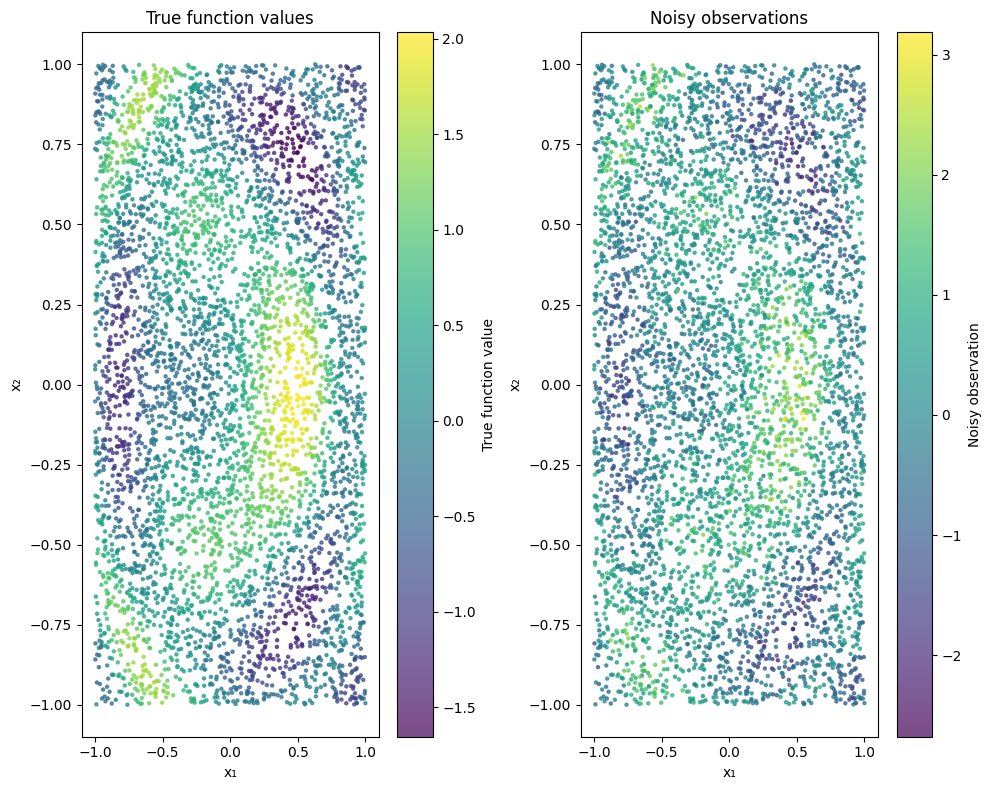

In [73]:
# --- Parameters ---
n = 1_000_000  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale = 0.3
true_variance = 1.0
true_noise_variance = 0.2
dtype = torch.float64  # Use float64 for numerical stability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

# --- Define the true function ---
def true_function(x):
    """
    A 2D function to generate synthetic data
    x: tensor of shape [n, 2]
    """
    # Example of a non-linear function with some interesting features
    return torch.sin(3 * x[:, 0]) * torch.cos(4 * x[:, 1]) + \
           0.5 * torch.exp(-((x[:, 0] - 0.3)**2 + (x[:, 1] + 0.3)**2) / 0.3) + \
           0.7 * torch.sin(2 * torch.pi * (x[:, 0]**2 + x[:, 1]**2))

# --- Generate target values with noise ---
# Compute true function values
f_true = true_function(x)

# Add Gaussian noise
noise = torch.randn(n, dtype=dtype, device=device) * math.sqrt(true_noise_variance)
y = f_true + noise

print(f"Generated {n} points with shape {x.shape}")
print(f"Using device: {device}")

# --- Visualize a subset of the data ---
if d == 2:
    plt.figure(figsize=(10, 8))
    
    # Plot the first 5000 points (or fewer if n is smaller)
    subset_size = min(5000, n)
    
    # Scatter plot colored by function value
    plt.subplot(1, 2, 1)
    sc = plt.scatter(x[:subset_size, 0].cpu(), x[:subset_size, 1].cpu(), 
                     c=f_true[:subset_size].cpu(), cmap='viridis', s=5, alpha=0.7)
    plt.colorbar(sc, label='True function value')
    plt.title('True function values')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    
    # Scatter plot colored by noisy observations
    plt.subplot(1, 2, 2)
    sc = plt.scatter(x[:subset_size, 0].cpu(), x[:subset_size, 1].cpu(), 
                     c=y[:subset_size].cpu(), cmap='viridis', s=5, alpha=0.7)
    plt.colorbar(sc, label='Noisy observation')
    plt.title('Noisy observations')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    
    plt.tight_layout()
    plt.show()


## Alt -- sample from a GP. 

In [74]:


# --- Parameters ---
n = 10_000  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale =0.3
true_variance = 1
true_noise_variance = 0.2
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1




Using device: cpu


In [75]:
# dat = torch.load('usa_temp_data.pt')
# x = dat['x']
# y= dat['y']
# d = 2

In [76]:
# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 20
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

In [77]:
from vanilla_gp_sampling import sample_gp_fast, sample_gp_matern

# # For squared exponential kernel
samples_se = sample_gp_fast(
    x,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
)
# # For Matern kernel
# samples_m32 = sample_gp_matern(
#     x,
#     nu=1.5,  # 3/2 Matern
#     length_scale=true_length_scale,
#     variance=true_variance,
#     noise_variance=true_noise_variance
# )
y = samples_se

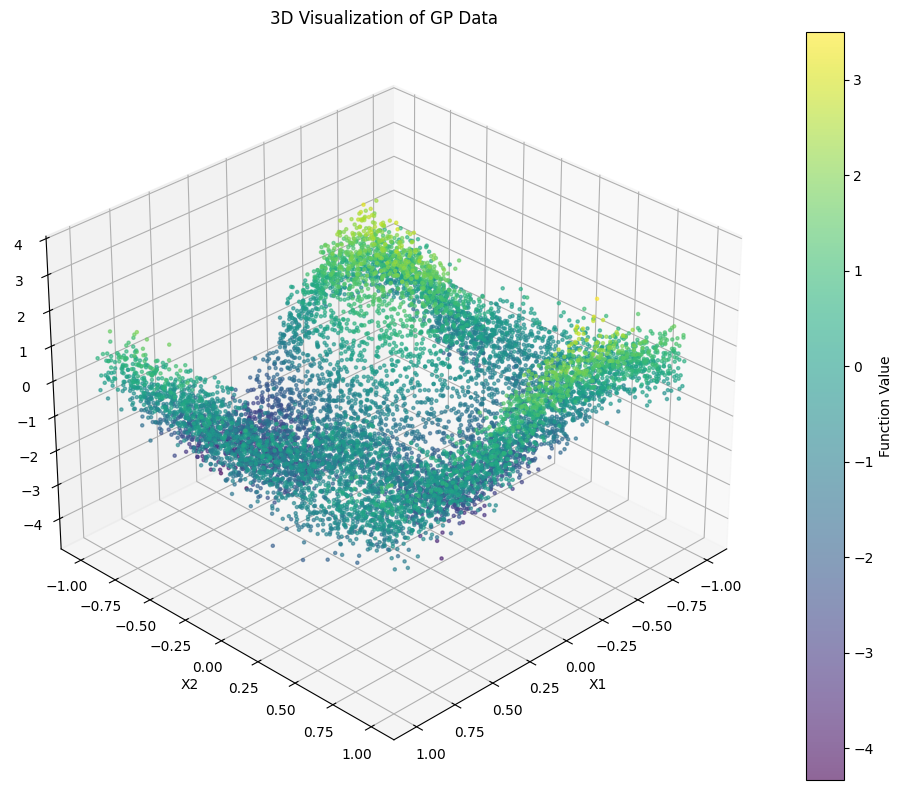

In [78]:
# Plot the data in 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
scatter = ax.scatter(x[:, 0].cpu().numpy(), 
                    x[:, 1].cpu().numpy(), 
                    y.cpu().numpy(), 
                    c=y.cpu().numpy(), 
                    cmap='viridis', 
                    alpha=0.6,
                    s=5)  # smaller point size for better visibility

# Add a color bar
plt.colorbar(scatter, ax=ax, label='Function Value')

# Set labels
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

# Add a title
ax.set_title('3D Visualization of GP Data')

# Adjust the viewing angle for better perspective
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


In [79]:
d= 2 
x0 = x.min(dim=0).values  
x1 = x.max(dim=0).values  
# input_range = x1.max() - x0.min()
# lengthscale = input_range * 0.1  # 10% of the input range
# kernel = SquaredExponential(dimension=d, lengthscale=lengthscale, variance=1)
kernel = SquaredExponential(dimension=d, lengthscale=0.5, variance=1)
# kernel = Matern(dimension=d, name='matern32', lengthscale=0.5, variance=1)
# Calculate lengthscale as a fraction of the input space range
init_kernel = kernel
sigmasq = torch.tensor(0.1) # noise variance 
EPSILON = 1e-4 # bound on kernel error 

In [80]:
x.shape

torch.Size([10000, 2])

# Using EFGPND 

In [81]:
cg_tol = EPSILON 
model = EFGPND(
    x        = x,               
    y        = y,               
    kernel   = kernel,
    sigmasq  = sigmasq,
    eps      = EPSILON,
    opts     = {
        "cg_tolerance"     : cg_tol,
        "early_stopping"   : True,
    },
)



## Hyperparameter learning

In [82]:
torch.manual_seed(42)
print(f'init kernel: {kernel}')
kernel = init_kernel
kernel.lengthscale = 0.1

model = EFGPND(x, y, kernel, sigmasq, EPSILON).optimize_hyperparameters(
    epsilon_values       = [1e-4],
    trace_samples_values = [10],
    base_lr              = 0.001,
    max_iters            = 50,
    x0 = x0, x1 = x1,                    
)
print("final hyperparams",model.kernel.lengthscale,model.kernel.variance,model.sigmasq)




init kernel: dimension=2 lengthscale=0.5 variance=1.0 num_hypers=3 hypers=['lengthscale', 'variance']
Auto-scaled learning rate: 0.000091 (base_lr=0.001, n_samples=10000)
[ε=0.0001 | J=10] iter   0  ℓ=0.1061  σ_f²=0.9883  σ_n²=0.1538
grad: tensor([ -6465.6703,    129.8424, -47355.3396], dtype=torch.float64)
[ε=0.0001 | J=10] iter  10  ℓ=0.1729  σ_f²=0.9164  σ_n²=0.2007
grad: tensor([-2422.2032,    62.5194,   -54.4356], dtype=torch.float64)
[ε=0.0001 | J=10] iter  20  ℓ=0.229  σ_f²=0.8816  σ_n²=0.2012
grad: tensor([-1059.7148,    36.1643,    -6.2520], dtype=torch.float64)
[ε=0.0001 | J=10] iter  30  ℓ=0.2689  σ_f²=0.8632  σ_n²=0.2014
grad: tensor([-489.0644,   18.8504,   -3.7659], dtype=torch.float64)
[ε=0.0001 | J=10] iter  40  ℓ=0.29  σ_f²=0.8551  σ_n²=0.2016
grad: tensor([-265.7367,   13.7861,  -21.0393], dtype=torch.float64)
└─ finished ε=0.0001, J=10 in 4.8s
final hyperparams 0.29993292794711235 0.8495989208230416 tensor(0.2017, dtype=torch.float64)


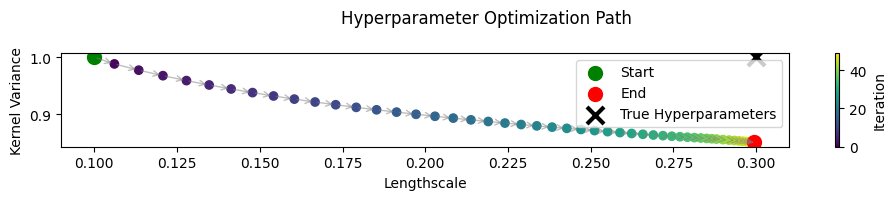

In [83]:
# Plot the hyperparameter optimization path in 2D
import matplotlib.pyplot as plt

# Extract hyperparameter history from the model's training log
training_log = model.training_log[0]
lengthscale_history = training_log['tracked_hyperparameters']['lengthscale']
variance_history = training_log['tracked_hyperparameters']['variance']

# Create a figure for the 2D plot
fig, ax = plt.subplots(figsize=(10, 2))
fig.suptitle('Hyperparameter Optimization Path')

# Plot lengthscale versus kernel variance
scatter = ax.scatter(lengthscale_history, variance_history, c=range(len(lengthscale_history)), cmap='viridis')
ax.set_xlabel('Lengthscale')
ax.set_ylabel('Kernel Variance')

# Add colorbar to show iteration progression
cbar = plt.colorbar(scatter)
cbar.set_label('Iteration')

# Add arrows to show direction of optimization
for i in range(len(lengthscale_history)-1):
    ax.annotate('', 
                xy=(lengthscale_history[i+1], variance_history[i+1]),
                xytext=(lengthscale_history[i], variance_history[i]),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

# Mark start and end points
ax.scatter(lengthscale_history[0], variance_history[0], color='green', s=100, label='Start')
ax.scatter(lengthscale_history[-1], variance_history[-1], color='red', s=100, label='End')
# Add true hyperparameters if available
# Assuming the true hyperparameters are the ones used to generate the data
# If you have different true values, replace these with the correct ones


# Plot the true hyperparameters as an X
ax.scatter(true_length_scale, true_variance, 
           marker='x', color='black', s=150, linewidth=3, 
           label='True Hyperparameters')


ax.legend()

plt.tight_layout()
plt.show()


## Fitting posterior mean

In [84]:
# Time different variance estimation methods
import time

# No variance
start_time = time.time()
mean_no_var, _ = model.fit().predict(x_new, return_variance=False)
no_var_time = time.time() - start_time
print(f"Time without variance: {no_var_time:.4f} seconds")


Time without variance: 0.4004 seconds


# Posterior variance -- Stochastic Estimate

In [85]:


# Stochastic variance
start_time = time.time()
hutchinson_probes = 1000
mean, stoch_var = model.predict(x_new, return_variance=True, variance_method="stochastic", hutchinson_probes=hutchinson_probes)
stoch_var_time = time.time() - start_time
print(f"Time with stochastic variance, x_new.shape = {x_new.shape}, {hutchinson_probes} probes: {stoch_var_time:.4f} seconds")




Time with stochastic variance, x_new.shape = torch.Size([400, 2]), 1000 probes: 8.9688 seconds


## Posterior variance -- regular method

In [86]:
# Regular variance
start_time = time.time()
mean, var = model.predict(x_new, return_variance=True, variance_method="regular")
reg_var_time = time.time() - start_time
print(f"Time with regular variance, x_new.shape = {x_new.shape}: {reg_var_time:.4f} seconds")

Time with regular variance, x_new.shape = torch.Size([400, 2]): 3.3562 seconds


# Visualization

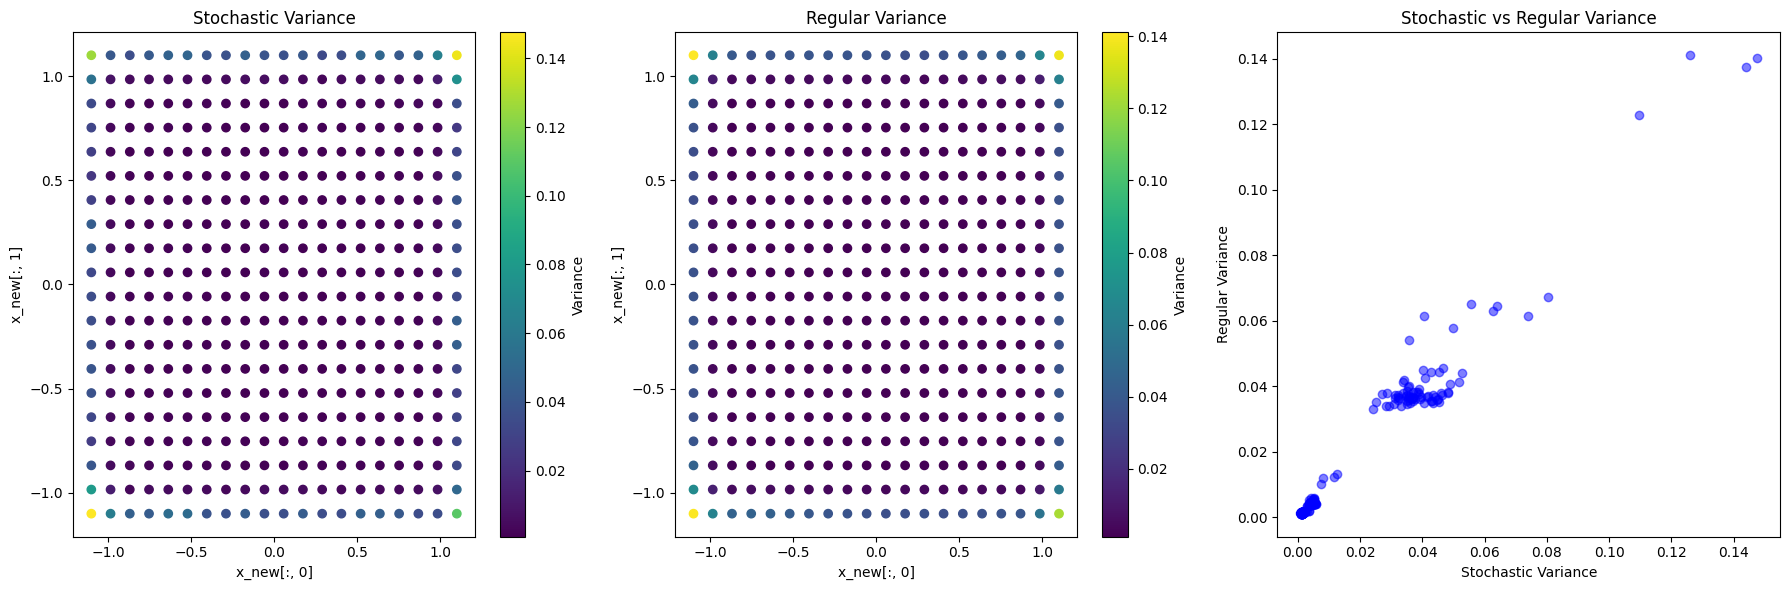

In [87]:
# Subplots for 2D plot of variance with respect to x_new grid for stochastic and regular variance
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Stochastic Variance
sc1 = axs[0].scatter(x_new[:, 0].cpu().numpy(), x_new[:, 1].cpu().numpy(), c=stoch_var.cpu().numpy(), cmap='viridis')
axs[0].set_title('Stochastic Variance')
axs[0].set_xlabel('x_new[:, 0]')
axs[0].set_ylabel('x_new[:, 1]')
fig.colorbar(sc1, ax=axs[0], label='Variance')

# Plot for Regular Variance
sc2 = axs[1].scatter(x_new[:, 0].cpu().numpy(), x_new[:, 1].cpu().numpy(), c=var.cpu().numpy(), cmap='viridis')
axs[1].set_title('Regular Variance')
axs[1].set_xlabel('x_new[:, 0]')
axs[1].set_ylabel('x_new[:, 1]')
fig.colorbar(sc2, ax=axs[1], label='Variance')

# Plot for Stochastic vs Regular Variance
sc3 = axs[2].scatter(stoch_var.cpu().numpy(), var.cpu().numpy(), c='blue', alpha=0.5)
axs[2].set_title('Stochastic vs Regular Variance')
axs[2].set_xlabel('Stochastic Variance')
axs[2].set_ylabel('Regular Variance')

plt.tight_layout()
plt.show()


In [88]:
# add plot of fit and true function

if d == 2:

    import plotly.graph_objects as go
    import numpy as np
    from scipy.interpolate import griddata

    # --- Prepare Data for Plotting ---
    # Extract x1, x2 coordinates and mean values from tensors
    x1 = x_new[:, 0].cpu().numpy()
    x2 = x_new[:, 1].cpu().numpy()
    mean_values = mean.cpu().numpy()

    # Create a grid for the surface plot
    x1_grid = np.linspace(x1.min(), x1.max(), 100)
    x2_grid = np.linspace(x2.min(), x2.max(), 100)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)

    # Interpolate mean values onto the grid for smooth surface visualization
    mean_surface = griddata(
        points=(x1, x2), 
        values=mean_values, 
        xi=(X1, X2), 
        method='cubic'
    )

    # --- Create Interactive 3D Plot ---
    fig = go.Figure()

    # Add the mean surface with transparency
    fig.add_trace(go.Surface(
        z=mean_surface,
        x=X1,
        y=X2,
        colorscale='Viridis',
        opacity=0.9,  # Increased opacity for better visibility
        name='EFGP Mean',
        colorbar=dict(
            title=dict(
                text="Mean Value",
                font=dict(size=14)
            ),
            tickfont=dict(size=12)
        )
    ))

    # Add scatter points for the true data with much higher transparency
    # Sample only a subset of points to reduce clutter
    sample_size = min(500, len(x))  # Limit to 500 points max
    indices = np.random.choice(len(x), sample_size, replace=False)
    
    fig.add_trace(go.Scatter3d(
        x=x[indices, 0].cpu().numpy(),
        y=x[indices, 1].cpu().numpy(),
        z=y[indices].cpu().numpy(),
        mode='markers',
        marker=dict(
            size=2,  # Even smaller scatter points
            color='red',
            opacity=0.15,  # Much higher transparency
            symbol='circle'
        ),
        name='True Data (Sample)'
    ))

    # --- Update Layout for Better Visualization ---
    fig.update_layout(
        scene=dict(
            aspectmode='manual',
            aspectratio=dict(x=1.5, y=1.5, z=1), # Make x and y dimensions wider relative to z
            xaxis=dict(
                title=dict(
                    text='x₁',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            yaxis=dict(
                title=dict(
                    text='x₂',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            zaxis=dict(
                title=dict(
                    text='Mean/True Data',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.2)  # Adjusted camera angle for better view
            )
        ),
        title=dict(
            text='EFGP Mean and True Data',
            font=dict(size=18),
            x=0.5,  # Center the title
            xanchor='center'
        ),
        legend=dict(
            x=0.8,
            y=0.9,
            font=dict(size=12),
            bgcolor='rgba(255, 255, 255, 0.8)',  # Add a semi-transparent background
            bordercolor='black',
            borderwidth=1
        ),
        margin=dict(l=0, r=0, t=50, b=0),  # Reduce margins for a cleaner look
        width=800,  # Increase figure width
        height=600   # Increase figure height
    )

    # Display the plot
    fig.show()


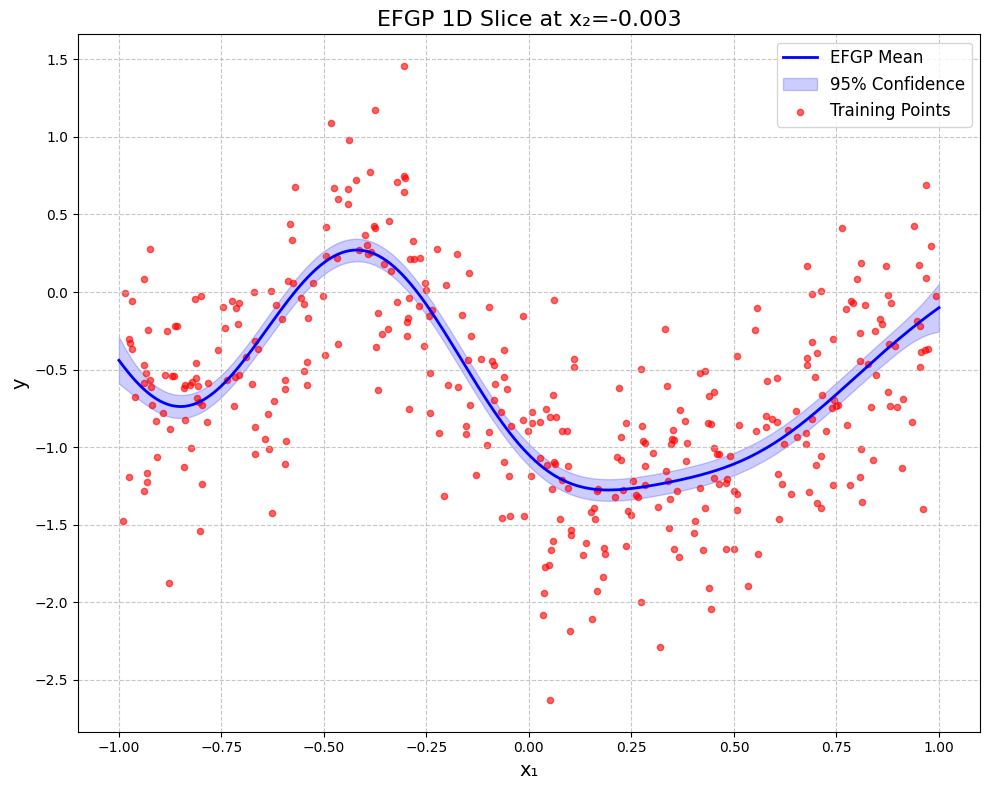

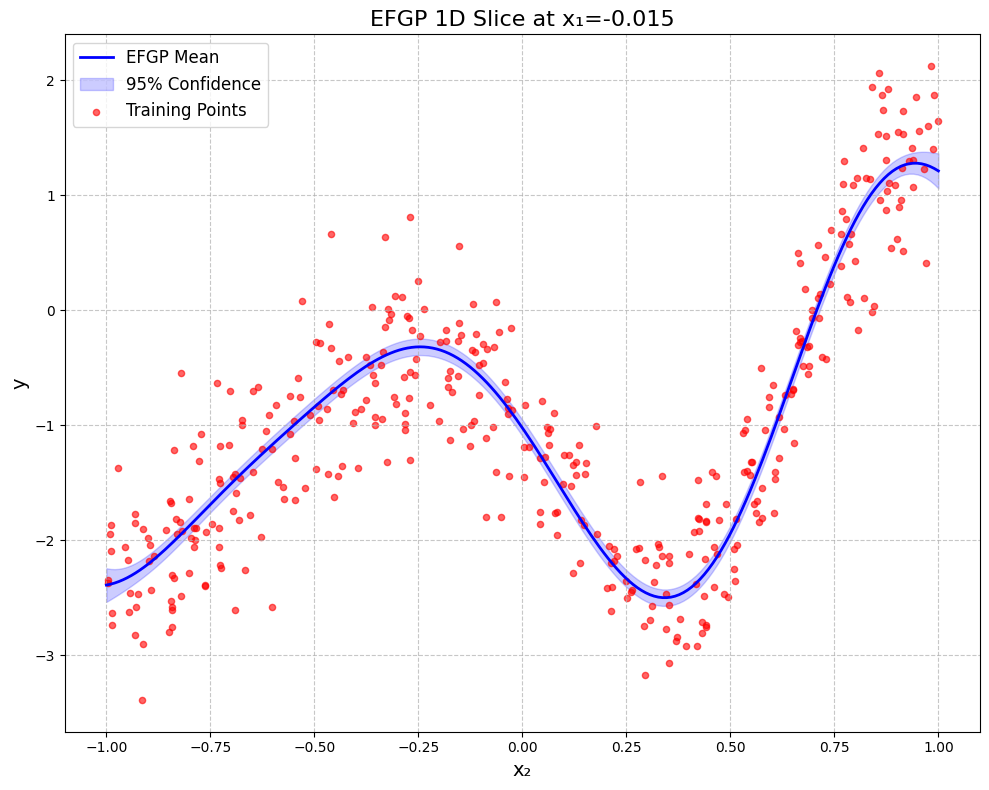

In [89]:
# Plot mean fit versus training points in 1D slice
def plot_1d_slice(model, x_train, y_train, dimension=0, slice_value=None, num_points=200):
    """
    Plot a 1D slice of the model's predictions against training points.
    
    Parameters:
    -----------
    model : EFGPND
        The fitted EFGP model
    x_train : torch.Tensor
        Training input points
    y_train : torch.Tensor
        Training target values
    dimension : int
        The dimension to vary (0 for x₁, 1 for x₂)
    slice_value : float
        The value to fix for the other dimension. If None, uses the median.
    num_points : int
        Number of points to use for the slice
    """
    # Determine dimensions
    fixed_dim = 1 - dimension  # The dimension to keep fixed
    
    # If slice_value is not provided, use the median of the fixed dimension
    if slice_value is None:
        slice_value = x_train[:, fixed_dim].median().item()
    
    # Get the range for the varying dimension
    min_val = x_train[:, dimension].min().item()
    max_val = x_train[:, dimension].max().item()
    
    # Create points along the slice
    x_slice = torch.linspace(min_val, max_val, num_points, device=x_train.device)
    
    # Create full input points for prediction
    x_pred = torch.zeros((num_points, 2), device=x_train.device)
    x_pred[:, dimension] = x_slice
    x_pred[:, fixed_dim] = slice_value
    
    # Get predictions
    mean_pred, var_pred = model.predict(x_pred, return_variance=True,variance_method="regular",)
    # mean_pred, var_pred = model.predict(x_pred, return_variance=True,variance_method="stochastic",hutchinson_probes=1000)
    
    # Find training points close to the slice
    tolerance = (max_val - min_val) / 50  # Adjust tolerance as needed
    mask = torch.abs(x_train[:, fixed_dim] - slice_value) < tolerance
    x_train_slice = x_train[mask, dimension]
    y_train_slice = y_train[mask]
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot the mean prediction
    plt.plot(x_slice.cpu().numpy(), mean_pred.cpu().numpy(), 'b-', linewidth=2, label='EFGP Mean')
    
    # Plot confidence intervals (±2 standard deviations)
    std_pred = torch.sqrt(var_pred)
    plt.fill_between(
        x_slice.cpu().numpy(),
        (mean_pred - 2 * std_pred).cpu().numpy(),
        (mean_pred + 2 * std_pred).cpu().numpy(),
        color='b', alpha=0.2, label='95% Confidence'
    )
    
    # Plot training points
    plt.scatter(x_train_slice.cpu().numpy(), y_train_slice.cpu().numpy(), 
                c='r', s=20, alpha=0.6, label='Training Points')
    
    # Add labels and title
    dim_label = "x₁" if dimension == 0 else "x₂"
    fixed_dim_label = "x₂" if dimension == 0 else "x₁"
    plt.xlabel(dim_label, fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title(f'EFGP 1D Slice at {fixed_dim_label}={slice_value:.3f}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt.gcf()

# Create a 1D slice plot for the x₁ dimension
fig1 = plot_1d_slice(model, x, y, dimension=0)
plt.show()

# Create a 1D slice plot for the x₂ dimension
fig2 = plot_1d_slice(model, x, y, dimension=1)
plt.show()


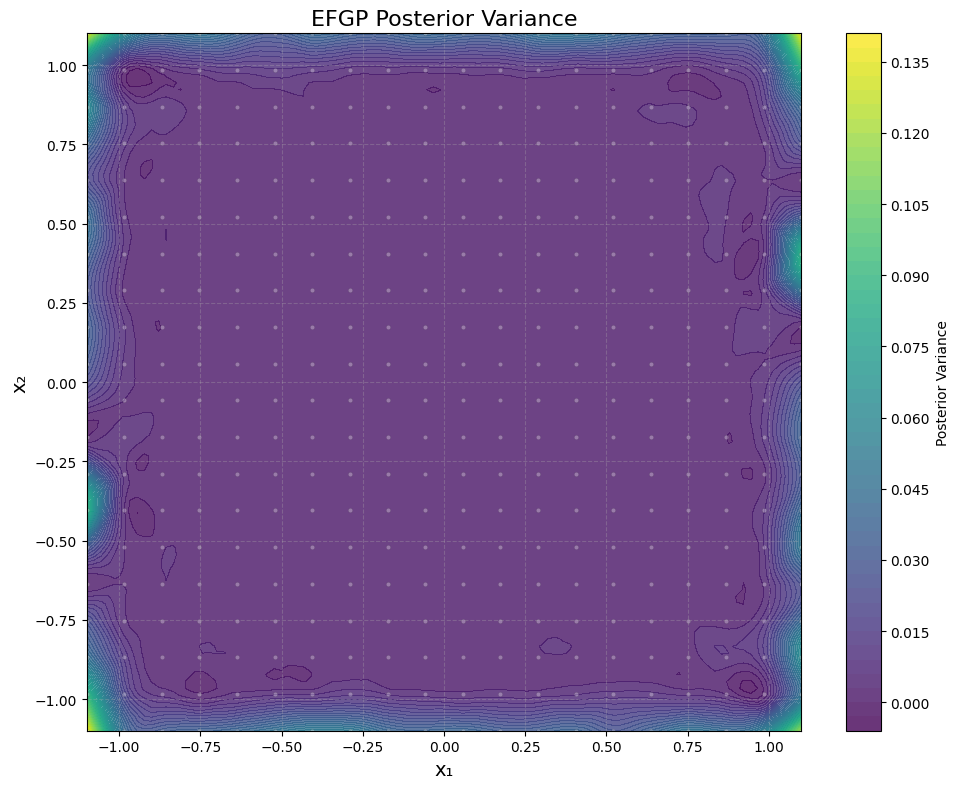

In [90]:
# Use x_new directly for visualization
x_grid = x_new

# Compute posterior mean and variance on the grid
mean_grid, var_grid = model.predict(x_grid, return_variance=True, variance_method="stochastic", hutchinson_probes=100)

# Extract x and y coordinates for plotting
x_coords = x_grid[:, 0].numpy()
y_coords = x_grid[:, 1].numpy()

# Create a grid for interpolation
n_grid = 100  # Number of points in each dimension
xi = np.linspace(min(x_coords), max(x_coords), n_grid)
yi = np.linspace(min(y_coords), max(y_coords), n_grid)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolate the variance values onto the regular grid
zi_grid = griddata((x_coords, y_coords), var_grid.numpy(), (xi_grid, yi_grid), method='cubic')

# Create a filled contour plot of the variance
plt.figure(figsize=(10, 8))
contour = plt.contourf(xi_grid, yi_grid, zi_grid, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(contour, label='Posterior Variance')

# Optionally overlay the original points
plt.scatter(x_coords, y_coords, c='white', s=10, alpha=0.3, edgecolors='k', linewidths=0.2)

plt.xlabel('x₁', fontsize=14)
plt.ylabel('x₂', fontsize=14)
plt.title('EFGP Posterior Variance', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Alternative: Create an interactive 3D surface plot with Plotly
import plotly.graph_objects as go
import numpy as np

# Create a 3D surface plot
fig = go.Figure(data=[
    go.Surface(
        x=xi_grid,
        y=yi_grid,
        z=zi_grid,
        colorscale='Viridis',
        opacity=0.9,
        colorbar=dict(title='Variance')
    )
])

# Optionally add the original points as scatter
fig.add_trace(go.Scatter3d(
    x=x_coords,
    y=y_coords,
    z=var_grid.numpy(),
    mode='markers',
    marker=dict(
        size=3,
        color='white',
        opacity=0.5
    ),
    showlegend=False
))

fig.update_layout(
    title='EFGP Posterior Variance',
    scene=dict(
        xaxis_title='x₁',
        yaxis_title='x₂',
        zaxis_title='Variance',
        camera=dict(eye=dict(x=1.25, y=1.25, z=1))
    ),
    width=800,
    height=600
)

fig.show()
